# Extending Ibis Part 2: Adding a New Reduction Expression

This notebook will show you how to add a new *reduction* operation `last_date` to the existing backend SQLite.

A reduction operation is a function that maps $N$ rows to 1 row, for example the `sum` function.

## Description

We're going to add a **`last_date`** function to ibis. `last_date` simply returns the latest date of a list of dates.

## Step 1: Define the Operation

Let's define the `last_date` operation as a function that takes any date column as input and returns a date:

```python
import datetime
import typing

def last_date(dates: typing.List[datetime.date]) -> datetime.date:
    """Latest date"""
```

In [1]:
import ibis.expr.datatypes as dt
import ibis.expr.rules as rlz

from ibis.expr.operations import Reduction, Arg


class LastDate(Reduction):
    arg = Arg(rlz.column(rlz.date))
    where = Arg(rlz.boolean, default=None)
    output_type = rlz.scalar_like('arg')

We just defined a `LastDate` class that takes one date column as input, and returns a scalar output of the same type as the input. This matches both the requirements of a reduction and the spepcifics of the function that we want to implement.

**Note**: It is very important that you write the correct argument rules and output type here. The expression *will not work* otherwise.

## Step 2: Define the API

Because every reduction in ibis has the ability to filter out values during aggregation (a typical feature in databases and analytics tools), to make an expression out of ``LastDate`` we need to pass an additional argument: `where` to our `LastDate` constructor.

In [2]:
from ibis.expr.types import (
    DateColumn,
)  # not DateValue! reductions are only valid on columns


def last_date(date_column, where=None):
    return LastDate(date_column, where=where).to_expr()


DateColumn.last_date = last_date

## Interlude: Create some expressions using `last_date`

In [3]:
import ibis

In [4]:
people = ibis.table(
    [('name', 'string'), ('country', 'string'), ('date_of_birth', 'date')],
    name='people',
)

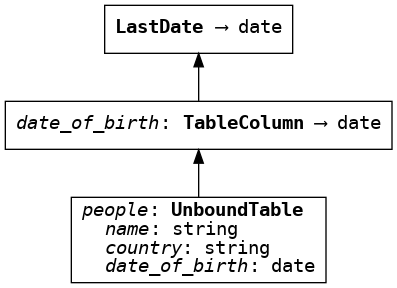

In [5]:
people.date_of_birth.last_date()

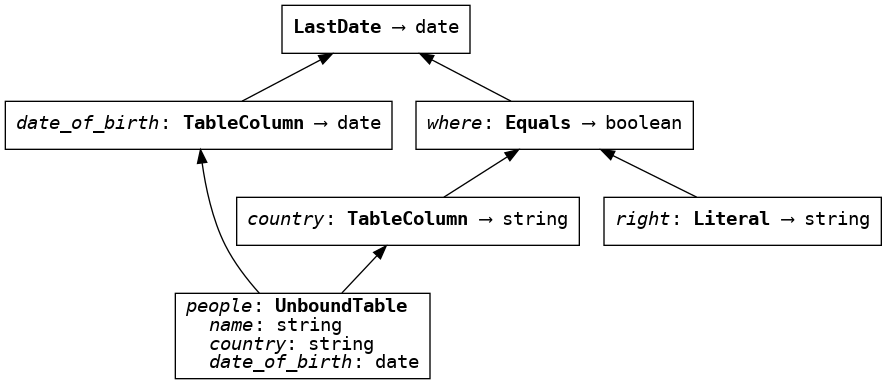

In [6]:
people.date_of_birth.last_date(people.country == 'Indonesia')

## Step 3: Turn the Expression into SQL

In [7]:
import sqlalchemy as sa


@ibis.sqlite.add_operation(LastDate)
def _last_date(translator, expr):
    # pull out the arguments to the expression
    arg, where = expr.op().args

    # compile the argument
    compiled_arg = translator.translate(arg)

    # call the appropriate SQLite function (`max` for the latest/maximum date)
    agg = sa.func.max(compiled_arg)

    # handle a non-None filter clause
    if where is not None:
        return agg.filter(translator.translate(where))
    return agg

## Step 4: Putting it all Together

In [8]:
import pathlib
import ibis

db_fname = str(
    pathlib.Path().resolve().parent.parent
    / 'tutorial'
    / 'data'
    / 'geography.db'
)

con = ibis.sqlite.connect(db_fname)

### Create and execute a `bitwise_and` expression

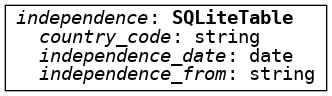

In [9]:
independence = con.table('independence')
independence

Last country to gain independence in our database:

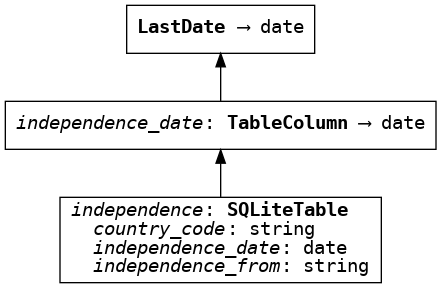

In [10]:
expr = independence.independence_date.last_date()
expr

In [11]:
sql_expr = expr.compile()
print(sql_expr)

SELECT max(t0.independence_date) AS tmp 
FROM base.independence AS t0


In [12]:
expr.execute()

Timestamp('2011-07-09 00:00:00')

Last country to gain independence from the Spanish Empire, using the `where` parameter:

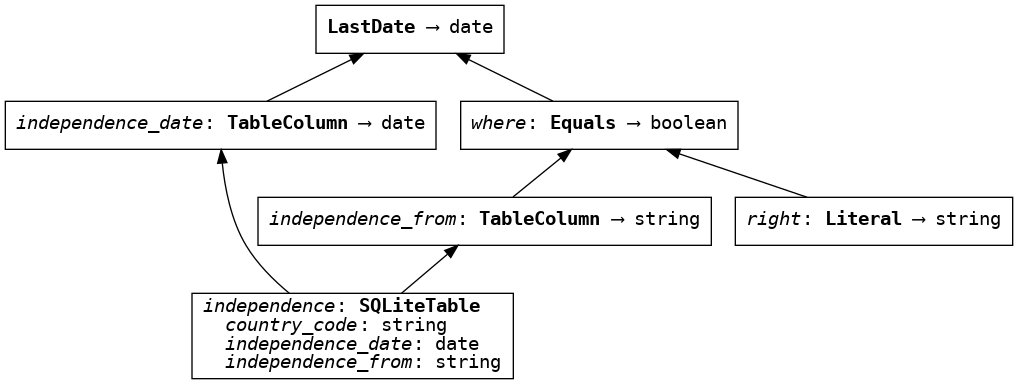

In [13]:
expr = independence.independence_date.last_date(
    where=independence.independence_from == 'Spanish Empire'
)
expr

In [14]:
result = expr.execute()
result

Timestamp('1898-06-12 00:00:00')